# SVM with Cira

### Cira

In [1]:
import cira

In [3]:
cira.auth.KEY_FILE = "../../alpc_key.json"
assert cira.auth.check_keys(), "the set keys dose not work"

In [4]:
from datetime import datetime

SYMBOL = "MSFT"

stk = cira.Stock(SYMBOL)
start = datetime(2017, 7, 1)
end = datetime(2023, 7, 1)
data = stk.historical_data_df(start, end)
data.head()

,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2017-07-03 04:00:00+00:00,MSFT,69.330,123.45,29.13,123.45,16268695.0,93948.0,68.336833
2017-07-05 04:00:00+00:00,MSFT,68.255,69.44,68.22,69.08,21176772.0,118512.0,68.917661
2017-07-06 04:00:00+00:00,MSFT,68.270,68.78,68.12,68.57,21117582.0,128258.0,68.476752
2017-07-07 04:00:00+00:00,MSFT,68.700,69.84,68.70,69.46,16878768.0,89306.0,69.366943
2017-07-10 04:00:00+00:00,MSFT,69.460,70.25,69.20,69.98,15014503.0,90915.0,69.926349


<Axes: xlabel='timestamp'>

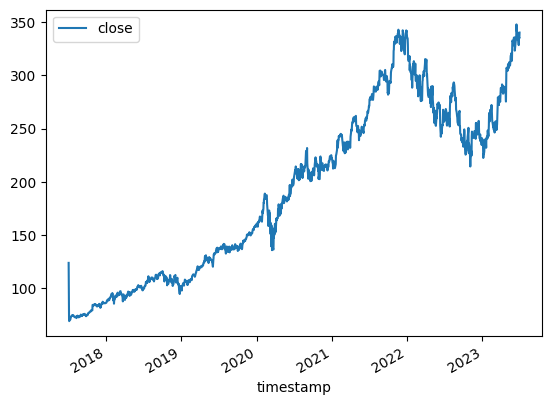

In [5]:
data.plot.line(y="close", use_index=True)

### SVM

In [32]:
from sklearn.svm import SVR

In [8]:
train_data = data[:int(len(data)*0.8)]
test_data =  data[int(len(data)*0.8):]


X = train_data[["open", "high", "low"]]
y = train_data['close']

X_test = test_data[["open", "high", "low"]]
y_test = test_data["close"] 

In [9]:
model = SVR()
model.fit(X, y)

SVR()

In [11]:
from sklearn.metrics import mean_squared_error

predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)

print("mean squared error: ", mse)
len(predictions), len(y_test)

mean squared error:  128.84487717618805


(302, 302)

Text(0.5, 1.0, 'predictions vs reality')

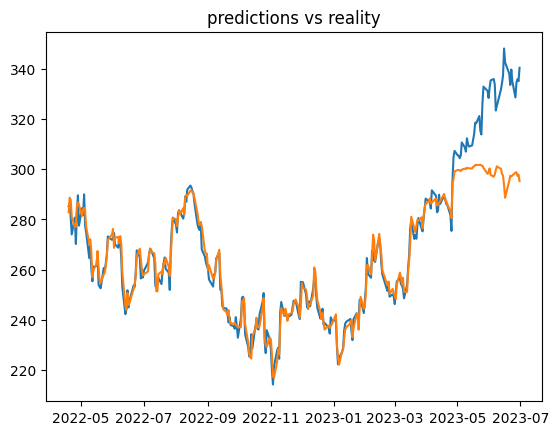

In [18]:
import matplotlib.pyplot as plt

plt.plot(X_test.index, y_test)
plt.plot(X_test.index, predictions)
plt.title("predictions vs reality")


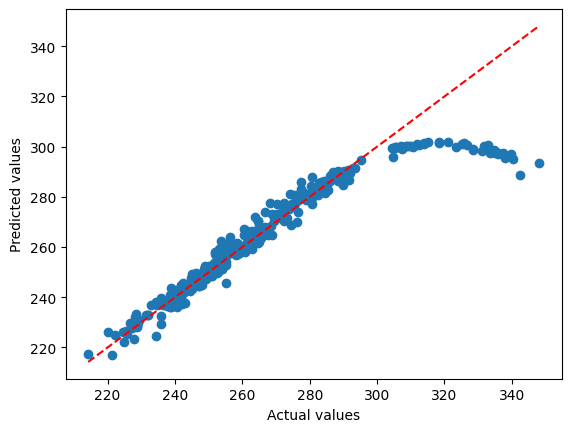

In [17]:

plt.scatter(y_test, predictions)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

plt.xlabel('Actual values')
plt.ylabel('Predicted values')

plt.show()

### Cira Backtest

In [29]:
from cira.backtest import model_vs_buy_and_hold, back_test

model: 3002354.457001308$
Buy and hold profit: 5305000.0$
diff: 0.5659480597551947


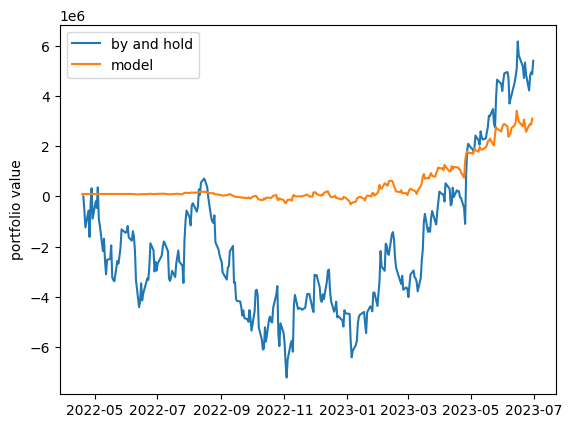

In [33]:
INITIAL_CAPITAL = 100_000.0
THRESHOLD = 0.01

bh, res = model_vs_buy_and_hold(model, test_data, ["open", "high", "low"], "close", threshold=THRESHOLD, capital=INITIAL_CAPITAL)


bh_prof = bh[-1] - INITIAL_CAPITAL
model_prof = res['capital'][-1] - INITIAL_CAPITAL
print(f"model: {model_prof}$")
print(f"Buy and hold profit: {bh_prof}$")
print(f"diff: {model_prof / bh_prof}")


plt.plot(bh, label="by and hold")
plt.plot(res, label="model")
plt.ylabel("portfolio value")
plt.legend()
plt.show()